<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Reoresebtations using Joint Embedding Predictive Architectures (JEPA)
(Fayyaz MINHAS)

---

## 1. Motivation: representation learning via predictability

Let $x \in \mathcal{X}$ denote an observed data instance.  
We assume $x$ is generated from an unobserved latent state $s \in \mathcal{S}$.

The goal of representation learning is to learn a mapping
$$
f_\theta : \mathcal{X} \to \mathbb{R}^d
$$
such that the representation
$$
z = f_\theta(x)
$$
captures the meaningful structure of $s$ while discarding noise.

JEPA is based on the principle:

> A good representation is one in which **related views of the same underlying state are predictable from one another in latent space**.

---

## 2. Structured views of an instance

From an instance $x$ (or equivalently a latent state $s$), we generate two related views:
$$
(x_c, x_t) \sim \mathcal{T}(x)
$$
where:
- $x_c$ is a **context view**
- $x_t$ is a **target view**
- $\mathcal{T}$ encodes known structure such as:
  - masking (images, text)
  - temporal offsets (time series, video)
  - spatial partitions (graphs, tissue)
  - modality pairing (multimodal data)

Optionally, we observe side-information:
$$
u \in \mathcal{U}
$$
(e.g. actions, metadata, conditioning variables).

---

## 3. Encoders and latent representations

We define an encoder
$$
f_\theta : \mathcal{X} \to \mathbb{R}^d
$$

and compute:

**Context embedding**
$$
z_c = f_\theta(x_c)
$$

**Target embedding**
$$
z_t = f_{\bar\theta}(x_t)
$$

The parameters $\theta$ and $\bar\theta$ share architecture but play **asymmetric roles**.

---

## 4. Latent prediction

We introduce a learnable predictor
$$
g_\phi : \mathbb{R}^{d_c} \times \mathcal{U} \to \mathbb{R}^d
$$

which produces a predicted target embedding:
$$
\hat z_t = g_\phi(z_c, u)
$$

The predictor absorbs structure such as:
- temporal dynamics
- spatial propagation
- modality translation
- action conditioning

---

## 5. The JEPA objective

Learning is performed entirely in latent space:
$$
\boxed{
\mathcal{L}
=
\mathbb{E}_{(x_c,x_t)}
\Big[
\ell\big(
g_\phi(f_\theta(x_c), u),
\operatorname{sg}(f_{\bar\theta}(x_t))
\big)
\Big]
}
$$

where:
- $\ell(\cdot,\cdot)$ is a distance (e.g. $\ell(a,b)=\|a-b\|^2$ or cosine distance)
- $\operatorname{sg}(\cdot)$ denotes **stop-gradient**

This single expression defines the JEPA framework.

---

## 6. Stop-gradient as an intervention

For any variable $y = \operatorname{sg}(x)$:

- forward pass:
$$
y = x
$$
- backward pass:
$$
\frac{\partial y}{\partial x} = 0
$$

Thus, $x$ contributes to the loss but **cannot adapt to reduce it**.

### Causal interpretation

Stop-gradient corresponds to a causal intervention:
$$
z_t := \mathrm{do}(z_t = f_{\bar\theta}(x_t))
$$

This severs the feedback path from the loss to $\bar\theta$, enforcing an **arrow of explanation**:
$$
z_c \;\to\; \hat z_t \;\approx\; z_t
$$

Conceptually:
> One representation defines *what counts as correct*; the other must *explain it*.

---

## 7. The role of $\bar\theta$ as an operator

The target parameters are defined as a **fixed functional of training history**:
$$
\boxed{
\bar\theta_t = \mathcal{F}(\theta_0, \theta_1, \ldots, \theta_t)
}
$$

where:
- $\mathcal{F}$ is fixed and non-learned
- gradients do not flow through $\mathcal{F}$

### Examples of $\mathcal{F}$

**Exponential moving average**
$$
\bar\theta_t = \tau \bar\theta_{t-1} + (1-\tau)\theta_t
$$

**Stop-gradient identity**
$$
\bar\theta_t = \theta_t
$$

**Sliding-window average**
$$
\bar\theta_t = \frac{1}{W}\sum_{k=t-W+1}^t \theta_k
$$

**Projection-based operator**
$$
\bar\theta_t = \Pi_{\mathcal{M}}\big(\mathcal{A}(\theta_{0:t})\big)
$$

where $\mathcal{M}$ encodes structural constraints (e.g. orthogonality, sparsity, spatial bases).

Thus, $\bar\theta$ defines a **stable reference geometry** rather than a second learner.

---

## 8. What JEPA learns implicitly

JEPA encourages representations satisfying:
$$
z_t \approx g_\phi(z_c, u)
$$

This implies that $z$:
- discards unpredictable noise
- preserves shared structure
- evolves smoothly under known transformations

Hence, JEPA learns **latent coordinates aligned with the underlying state $s$**.

---

## 9. Examples across domains

The same formulation applies by changing $\mathcal{T}$, $u$, and $g_\phi$:

**Vision**
$$
x_c = \text{visible patches}, \quad x_t = \text{masked patch}
$$

**Time series / video**
$$
x_c = x_{1:t}, \quad x_t = x_{t+k}
$$

**Graphs / spatial data**
$$
x_c = \text{neighborhood}, \quad x_t = \text{held-out node or region}
$$

**Multimodal learning**
$$
x_c \in \mathcal{X}^{(1)}, \quad x_t \in \mathcal{X}^{(2)}
$$

No change to the loss is required.

---

## 10. What JEPA deliberately avoids

JEPA does not require:
$$
\text{reconstruction losses}, \quad \text{likelihood models}, \quad \text{negative samples}, \quad \text{labels}
$$

Learning is driven purely by **latent predictability**.

---

## 11. Summary

JEPA is a predictive latent representation learning framework in which an encoder $f_\theta$ is trained so that the embedding of a target view is predictable from the embedding of a context view. Stability is achieved by treating the target embedding as an intervened variable via stop-gradient, and by defining its parameters $\bar\theta$ as a fixed operator over the history of learned parameters. This separation between *what must be predicted* and *what may adapt* prevents collapse and yields structured, semantic, and transferable representations across domains.


## 12. Mapping the tutorial to the toy code (implementation logic)

This section explains how the representative cross-domain toy code below instantiates the JEPA framework introduced above, and how each implementation choice corresponds to a specific concept in the tutorial.

---

### 12.1 The toy world implements the latent-state assumption

In the code, the dataset explicitly constructs an unobserved latent state
$$
s \in \mathbb{R}^2
$$
and generates two different observed “domains” (modalities)
$$
x^{(A)} = h_A(s) + \epsilon_A,\qquad x^{(B)} = h_B(s) + \epsilon_B,
$$
where $h_A$ and $h_B$ are fixed nonlinear functions and $\epsilon_A,\epsilon_B$ are independent noise.

Conceptually:
- $s$ is the unobserved state in Section 1.
- $(x^{(A)}, x^{(B)})$ are two structured views of the same underlying state, implementing Section 2.

This makes the toy problem realistic: in practice, cross-domain pairs often share latent biology but differ in measurement mechanism, noise, and distortions.

---

### 12.2 The transformation $\mathcal{T}$ is “cross-domain pairing”

The tutorial describes
$$
(x_c, x_t)\sim \mathcal{T}(x).
$$
In the code, $\mathcal{T}$ is the pairing rule “same index corresponds to the same latent $s$,” producing
$$
x_c = x^{(A)},\qquad x_t = x^{(B)}
$$
(or symmetrically the reverse direction). This is a representative instance of $\mathcal{T}$ for multimodal or cross-domain JEPA.

No explicit $u$ is used in the toy, so $u$ can be understood as empty or omitted:
$$
u = \varnothing.
$$

---

### 12.3 Online encoders implement $f_\theta$

The tutorial defines encoders
$$
f_\theta:\mathcal{X}\to\mathbb{R}^d.
$$
In the code, there are two online encoders:
$$
f_{\theta_A}^{(A)}:\mathcal{X}^{(A)}\to\mathbb{R}^d,\qquad
f_{\theta_B}^{(B)}:\mathcal{X}^{(B)}\to\mathbb{R}^d.
$$
They are implemented as small MLPs `self.fA` and `self.fB`.

They produce:
$$
z_A = f_{\theta_A}^{(A)}(x^{(A)}),\qquad
z_B = f_{\theta_B}^{(B)}(x^{(B)}).
$$

These are the learned latent representations.

---

### 12.4 Predictors implement $g_\phi$ (latent translation)

The tutorial defines a predictor
$$
g_\phi:\mathbb{R}^{d_c}\times\mathcal{U}\to\mathbb{R}^d,
\qquad
\hat z_t = g_\phi(z_c,u).
$$

In the code, we instantiate cross-domain predictors:
$$
\hat z_B = g_{\phi_{A\to B}}(z_A),\qquad
\hat z_A = g_{\phi_{B\to A}}(z_B).
$$

These are implemented as `self.gA2B` and `self.gB2A`.

Interpretation:
- the predictors learn the “translation rule” between domain embeddings,
- which is how JEPA captures structure such as modality translation, temporal dynamics, or message passing (Section 4).

---

### 12.5 Target encoders implement $f_{\bar\theta}$

The tutorial defines the target embedding as
$$
z_t = f_{\bar\theta}(x_t).
$$

In the code, the target encoders are `self.fA_tgt` and `self.fB_tgt`, which are deep-copies of the online encoders. They produce:
$$
z_{A}^{\text{tgt}} = f_{\bar\theta_A}^{(A)}(x^{(A)}),\qquad
z_{B}^{\text{tgt}} = f_{\bar\theta_B}^{(B)}(x^{(B)}).
$$

These target embeddings define the “reference geometry” the online network must predict.

---

### 12.6 Stop-gradient is implemented by `no_grad` and `.detach()`

The tutorial defines stop-gradient $\operatorname{sg}(\cdot)$ as:
$$
y=\operatorname{sg}(x)\Rightarrow \frac{\partial y}{\partial x}=0.
$$

In the code, the target embeddings are computed under a no-gradient context and then detached:
- `with torch.no_grad(): ...`
- `z_t = z_t.detach()`

This enforces the intervention view:
$$
z_t := \mathrm{do}(z_t=f_{\bar\theta}(x_t)),
$$
meaning that during a gradient step, $z_t$ behaves as fixed evidence.

---

### 12.7 The JEPA loss is exactly the latent matching objective

The tutorial’s core objective is:
$$
\mathcal{L}
=
\mathbb{E}\Big[
\ell\big(
g_\phi(f_\theta(x_c),u),
\operatorname{sg}(f_{\bar\theta}(x_t))
\big)
\Big].
$$

In the code (with $u=\varnothing$), the loss is implemented as:
$$
\mathcal{L}
=
\|g_{\phi_{A\to B}}(f_{\theta_A}^{(A)}(x^{(A)}))-\operatorname{sg}(f_{\bar\theta_B}^{(B)}(x^{(B)}))\|_2^2
+
\|g_{\phi_{B\to A}}(f_{\theta_B}^{(B)}(x^{(B)}))-\operatorname{sg}(f_{\bar\theta_A}^{(A)}(x^{(A)}))\|_2^2.
$$

The second term is included to make the toy symmetric and to strengthen the shared latent alignment.

The code uses mean-squared error as $\ell(\cdot,\cdot)$.

---

### 12.8 $\bar\theta$ is updated as a fixed operator $\mathcal{F}$ (EMA)

The tutorial introduces:
$$
\bar\theta_t = \mathcal{F}(\theta_0,\ldots,\theta_t).
$$

In the code, $\mathcal{F}$ is EMA:
$$
\bar\theta_t=\tau\bar\theta_{t-1}+(1-\tau)\theta_t,
$$
implemented in `ema_update()`.

This is not learned. It is a fixed operator applied each training step, which makes the target encoder drift slowly and stabilizes training.

---

### 12.9 Why normalization appears (practical geometry control)

The code applies LayerNorm to predicted and target embeddings before measuring MSE. This implements a common practical refinement:

- it reduces sensitivity to global scaling,
- stabilizes training,
- encourages the loss to reflect angular/relative geometry.

This does not change the conceptual JEPA structure; it only improves numerical behavior.

---

### 12.10 The plot visualizes what JEPA learned

The visualization step computes embeddings
$$
z^{(A)} = f_{\theta_A}^{(A)}(x^{(A)}),
$$
then projects them to $2$ dimensions using PCA, producing a 2D representation.

The plot compares:
- the true latent state $s$ in $\mathbb{R}^2$,
- the 2D projection of the learned embedding.

If JEPA has learned a meaningful representation, the 2D embedding structure is typically a smooth deformation of the true latent structure, reflecting Section 8:

$$
z \approx \psi(s)
$$
for some representation function $\psi$ that discards noise and preserves shared structure.

---

### 12.11 One-line summary of the code’s logic

The code builds a world in which two domains share a latent state, then trains encoders so that the embedding of one domain can predict the embedding of the other in latent space, using stop-gradient to treat target embeddings as intervened evidence and EMA to define the target encoder as a stable operator over training history.


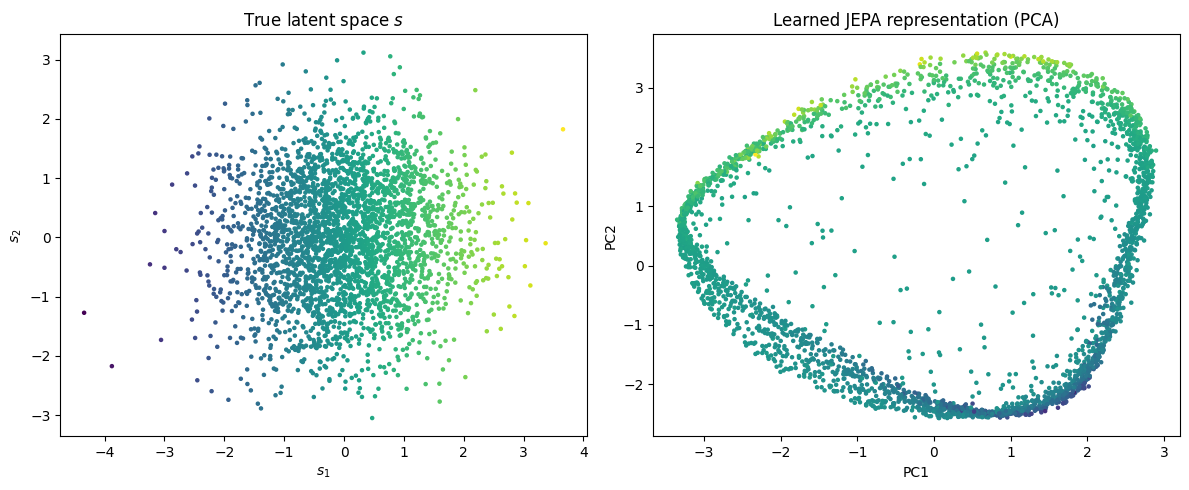

In [4]:
# This code instantiates the JEPA tutorial concretely:
#
# - latent state s ∈ S
# - two related views (x_c, x_t) via a transformation T
# - encoders f_θ and f_{θ̄}
# - predictor g_φ
# - stop-gradient as intervention
# - θ̄ implemented as an operator (EMA)
# - no reconstruction, no labels during training
#
# ============================================================

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) DATASET: latent state s → structured views (Section 1, 2)
# ------------------------------------------------------------
class PairedLatentDataset(Dataset):
    """
    This class instantiates the generative assumption:

        s ∈ R^2  (latent state)
        x^(A) = h_A(s) + noise
        x^(B) = h_B(s) + noise

    Conceptual mapping to the tutorial:
    ----------------------------------
    - s corresponds to the unobserved latent state in Section 1
    - x^(A), x^(B) are two related views of the same s
    - The pairing (xA, xB) plays the role of:
          (x_c, x_t) ~ T(x)

    This is a *cross-domain* version of T:
    modality A ↔ modality B
    """
    def __init__(self, n=15000, noise_std=0.1, seed=0):
        torch.manual_seed(seed)

        # Latent state s ∈ S
        self.s = torch.randn(n, 2)

        # Fixed nonlinear maps h_A, h_B (unknown to the learner)
        WA = torch.randn(2, 10) * 1.2
        WB = torch.randn(2, 20) * 0.8
        bA = torch.randn(10) * 0.2
        bB = torch.randn(20) * 0.2

        # Domain-specific observations (views)
        xA = torch.tanh(self.s @ WA + bA) + 0.5 * torch.sin(self.s @ (WA * 0.7) - bA)
        xB = torch.relu(self.s @ WB + bB) - 0.3 * torch.cos(self.s @ (WB * 0.9) + bB)

        # Add unpredictable noise (what JEPA should discard)
        xA = xA + noise_std * torch.randn_like(xA)
        xB = xB + noise_std * torch.randn_like(xB)

        self.xA = xA
        self.xB = xB

    def __len__(self):
        return self.s.shape[0]

    def __getitem__(self, idx):
        # s is returned only for *evaluation*, never for training
        return self.xA[idx], self.xB[idx], self.s[idx]


# ------------------------------------------------------------
# 2) MLP helper = generic function approximator
# ------------------------------------------------------------
def mlp(in_dim, hidden_dim, out_dim, depth=3):
    """
    Used to instantiate:
    - encoders f_θ
    - predictors g_φ

    The specific architecture is not essential to JEPA;
    what matters is *where* it appears in the computational graph.
    """
    layers = []
    d = in_dim
    for _ in range(depth - 1):
        layers += [nn.Linear(d, hidden_dim), nn.GELU()]
        d = hidden_dim
    layers += [nn.Linear(d, out_dim)]
    return nn.Sequential(*layers)


# ------------------------------------------------------------
# 3) JEPA model (Sections 3, 4, 5, 6, 7)
# ------------------------------------------------------------
class JEPA_CrossDomain(nn.Module):
    """
    This module directly mirrors the JEPA equations:

        z_c      = f_θ(x_c)
        z_t      = f_{θ̄}(x_t)
        ẑ_t     = g_φ(z_c)
        L        = || ẑ_t − sg(z_t) ||

    with:
    - f_θ      = online encoders
    - f_{θ̄}   = target encoders (EMA operator)
    - sg(.)    = stop-gradient (intervention)
    """
    def __init__(self, dimA=10, dimB=20, zdim=16, hidden=128, ema_tau=0.996):
        super().__init__()
        self.ema_tau = ema_tau

        # ----------------------------
        # Online encoders f_θ
        # ----------------------------
        # These correspond to f_θ : X → R^d in Section 3
        self.fA = mlp(dimA, hidden, zdim)
        self.fB = mlp(dimB, hidden, zdim)

        # ----------------------------
        # Predictors g_φ
        # ----------------------------
        # These implement latent prediction (Section 4):
        #   ẑ_B = g_{A→B}(z_A)
        #   ẑ_A = g_{B→A}(z_B)
        self.gA2B = mlp(zdim, hidden, zdim, depth=2)
        self.gB2A = mlp(zdim, hidden, zdim, depth=2)

        # ----------------------------
        # Target encoders f_{θ̄}
        # ----------------------------
        # These define the *reference geometry*
        # θ̄ is NOT optimized by gradient descent
        self.fA_tgt = copy.deepcopy(self.fA)
        self.fB_tgt = copy.deepcopy(self.fB)
        for p in self.fA_tgt.parameters():
            p.requires_grad_(False)
        for p in self.fB_tgt.parameters():
            p.requires_grad_(False)

    # --------------------------------------------------------
    # θ̄ update = operator F(θ_0, …, θ_t)  (Section 7)
    # --------------------------------------------------------
    @torch.no_grad()
    def ema_update(self):
        """
        Implements:
            θ̄_t = τ θ̄_{t−1} + (1−τ) θ_t

        This is the concrete instantiation of:
            θ̄_t = F(θ_0, …, θ_t)

        Importantly:
        - This is NOT backprop
        - This is a fixed, non-learned operator
        """
        tau = self.ema_tau
        for p_tgt, p in zip(self.fA_tgt.parameters(), self.fA.parameters()):
            p_tgt.data.mul_(tau).add_((1 - tau) * p.data)
        for p_tgt, p in zip(self.fB_tgt.parameters(), self.fB.parameters()):
            p_tgt.data.mul_(tau).add_((1 - tau) * p.data)

    # --------------------------------------------------------
    # Forward = JEPA loss construction (Section 5)
    # --------------------------------------------------------
    def forward(self, xA, xB):
        # Context embeddings z_c = f_θ(x_c)
        zA = self.fA(xA)
        zB = self.fB(xB)

        # Target embeddings z_t = f_{θ̄}(x_t)
        # Stop-gradient implemented via no_grad + detach
        with torch.no_grad():
            zA_t = self.fA_tgt(xA)
            zB_t = self.fB_tgt(xB)

        # Latent predictions ẑ_t = g_φ(z_c)
        zB_hat = self.gA2B(zA)
        zA_hat = self.gB2A(zB)

        # Normalization stabilizes geometry (common in SSL)
        zA_hat = F.layer_norm(zA_hat, (zA_hat.shape[-1],))
        zB_hat = F.layer_norm(zB_hat, (zB_hat.shape[-1],))
        zA_t   = F.layer_norm(zA_t,   (zA_t.shape[-1],))
        zB_t   = F.layer_norm(zB_t,   (zB_t.shape[-1],))

        # JEPA loss:
        #   L = || g(f(x_c)) − sg(f_{θ̄}(x_t)) ||
        loss = F.mse_loss(zB_hat, zB_t) + F.mse_loss(zA_hat, zA_t)
        return loss


# ------------------------------------------------------------
# 4) Training loop (self-supervised learning)
# ------------------------------------------------------------
def train_demo(device="cpu"):
    ds = PairedLatentDataset()
    dl = DataLoader(ds, batch_size=256, shuffle=True, drop_last=True)

    model = JEPA_CrossDomain().to(device)
    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=2e-3,
        weight_decay=1e-4,
    )

    model.train()
    for step, (xA, xB, _) in enumerate(dl, start=1):
        xA, xB = xA.to(device), xB.to(device)

        # Self-supervised JEPA loss (no labels)
        loss = model(xA, xB)

        opt.zero_grad()
        loss.backward()
        opt.step()

        # θ̄ update via operator F
        model.ema_update()

        if step % 100 == 0:
            print(f"step {step:04d} | loss {loss.item():.4f}")
        if step >= 600:
            break

    return model, ds


# ------------------------------------------------------------
# 5) Visualization: what representation was learned?
# ------------------------------------------------------------
@torch.no_grad()
def plot_latent_space(model, ds, device="cpu", n_points=3000):
    """
    This corresponds to Section 8:

    We check whether the learned z aligns with the true latent s,
    even though s was never used for training.

    This demonstrates that JEPA recovered latent structure
    purely via predictability.
    """
    model.eval()

    idx = torch.randperm(len(ds))[:n_points]
    xA = ds.xA[idx].to(device)
    s = ds.s[idx].to(device)

    zA = model.fA(xA)
    zA = F.layer_norm(zA, (zA.shape[-1],))

    # PCA via SVD to visualize z in 2D
    zA_centered = zA - zA.mean(dim=0, keepdim=True)
    U, S, Vt = torch.linalg.svd(zA_centered, full_matrices=False)
    z2 = zA_centered @ Vt[:2].T

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(s[:, 0].cpu(), s[:, 1].cpu(), c=s[:, 0].cpu(), s=5)
    plt.title("True latent space $s$")
    plt.xlabel("$s_1$")
    plt.ylabel("$s_2$")

    plt.subplot(1, 2, 2)
    plt.scatter(z2[:, 0].cpu(), z2[:, 1].cpu(), c=s[:, 0].cpu(), s=5)
    plt.title("Learned JEPA representation (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 6) Run everything
# ------------------------------------------------------------
if __name__ == "__main__":
    device = "cpu"
    model, ds = train_demo(device=device)
    plot_latent_space(model, ds, device=device)
